In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import dalex as dx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

In [2]:
#df_modelos = pd.read_csv("data/datosFinales/df_modelos.csv", sep = ";")
df_modelos = pd.read_csv("../data/datosFinales/diferencias_2.csv", sep = ";")

#dropped columns which are 0
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.contains('diferencia_')]
categoricas = pd.read_csv("../data/categoricas.csv", sep = ",").squeeze().tolist()
print(len(categoricas))
#remove columns with many NAs
categoricas.remove('tipo_plastia')
categoricas.remove('via_asc_plastia')
print(len(categoricas))

30
28


In [3]:
df_modelos

,id_registro,sexo,edad,peso,talla,imc,neoadyuvancia,localizacion,tipo_histologico,ct,...,sat_oxig_diferencia2_5,temp_corp_diferencia2_5,frec_resp_diferencia2_5,neutrofilos_diferencia2_5,frec_card_diferencia2_5,linfocitos_diferencia2_5,eva_diferencia2_5,plaquetas_diferencia2_5,albumina_diferencia2_5,pcr_diferencia2_5
0,92-1,0.0,61.0,79.0,178.0,24.9,1.0,4.0,1.0,4.0,...,1.0,-0.2,-1.0,-0.528656,NaN,NaN,-2.0,0.206335,-0.9,-14.60
1,92-2,1.0,79.0,95.0,170.0,32.9,0.0,4.0,1.0,2.0,...,-1.0,-0.7,-8.0,0.025972,26.0,NaN,-2.0,0.423668,0.7,-7.70
2,92-3,0.0,74.0,94.0,175.0,30.7,1.0,4.0,NaN,4.0,...,-2.0,0.5,1.0,-0.316932,22.0,NaN,2.0,0.015873,0.2,113.60
3,92-4,0.0,74.0,63.0,168.0,22.3,2.0,3.0,1.0,5.0,...,-13.0,1.5,2.0,NaN,20.0,NaN,4.0,NaN,NaN,NaN
4,92-5,0.0,62.0,57.0,157.0,23.1,2.0,4.0,1.0,4.0,...,-3.0,0.2,0.0,0.961284,7.0,NaN,-2.0,-0.081526,0.8,-165.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,613-30,0.0,72.0,83.0,169.0,29.1,1.0,3.0,1.0,3.0,...,-1.0,-0.3,-1.0,-0.234513,-12.0,-0.495879,-1.0,0.096331,NaN,24.91
724,613-31,1.0,40.0,58.0,160.0,22.7,0.0,5.0,1.0,3.0,...,0.0,-0.2,-2.0,-0.109463,-11.0,-0.743461,-3.0,0.373588,NaN,7.88
725,613-32,0.0,59.0,82.0,171.0,28.0,1.0,7.0,1.0,2.0,...,0.0,-1.7,-7.0,-0.198163,-22.0,0.328282,-2.0,0.518792,NaN,-5.73
726,617-1,0.0,74.0,53.0,160.0,20.7,0.0,6.0,2.0,2.0,...,-1.0,-0.5,-2.0,-0.753551,-22.0,NaN,-2.0,0.289890,NaN,-174.00


In [4]:
idPats = np.unique(df_modelos.id_registro)

df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_5')]
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_4')]
df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_3')]
#df_modelos = df_modelos.loc[:, ~df_modelos.columns.str.endswith('_2')]

# Modelo Xgboost


In [5]:
np.random.seed(14)

In [6]:
df_tmp = df_modelos.copy()[df_modelos['fuga'] != -1]
cats = []

# label_encoder = LabelEncoder()
# for col in categoricas:
#     if col in df_tmp.columns:
#         df_tmp[col] = label_encoder.fit_transform(df_tmp[col])
#         cats.append(col)
    
columnas_a_eliminar = [col for col in df_tmp.columns if "fuga" in col]
X = df_tmp.drop(columnas_a_eliminar, axis=1)
X = X.drop(['id_registro'], axis=1)

y = df_tmp['fuga']

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [8]:
# Instanciar el codificador
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Ajustar y transformar las columnas categóricas
X_cat_encoded = encoder.fit_transform(X[cats])

# Crear DataFrame con los nuevos nombres de columnas
cat_encoded_df = pd.DataFrame(
    X_cat_encoded,
    columns=encoder.get_feature_names_out(cats),
    index=X.index  # mantener los índices originales
)

# Concatenar con el resto de columnas no categóricas
X_encoded = pd.concat([X.drop(columns=cats), cat_encoded_df], axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, stratify=y, random_state=14)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=14)

In [10]:
from sklearn.metrics import accuracy_score, f1_score

In [11]:
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': ['auc', 'error'],
    'max_depth': 4,  # Reducida desde 5
    'learning_rate': 0.001,  # Reducida desde 0.05
    'subsample': 0.3,  # Más bajo para más regularización
    'colsample_bytree': 0.7,
    'min_child_weight': 5,  # Aumentada desde 3
    'gamma': 0.3,  # Aumentada desde 0.2
    'reg_alpha': 2,  # Aumentada desde 1
    'reg_lambda': 15,  # Aumentada desde 10
    'scale_pos_weight': len(y_train[y_train==0])/len(y_train[y_train==1]) * 1.2,  # Balance ajustado
    'seed': 14,
    'tree_method': 'hist'
}

# Encode categorical variables in X_train and X_val
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Convertir a DMatrix

dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dtest = xgb.DMatrix(X_test_encoded)


#evals_result = {}
model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=2000,  # Más iteraciones posibles
    verbose_eval=50
)

y_proba_train = model.predict(dtrain)
y_pred_train = (y_proba_train >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TRAIN:")
print(confusion_matrix(y_train, y_pred_train))
print("\nReporte de clasificación TRAIN:")
print(classification_report(y_train, y_pred_train))

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train, y_pred_train)
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_train, y_pred_train)
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("F1 score:", f1)


y_proba_test = model.predict(dtest)
y_pred_test = (y_proba_test >= 0.5).astype(int)

print("\n=== RESULTADOS FINALES OPTIMIZADOS ===")
print(f"Threshold óptimo: {0.5:.4f}")
print("\nMatriz de confusión TEST:")
print(confusion_matrix(y_test, y_pred_test))
print("\nReporte de clasificación TEST:")
print(classification_report(y_test, y_pred_test))
#auc
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_proba_test)
print(f"AUC: {auc:.4f}")
f1 = f1_score(y_test, y_pred_test)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 score:", f1)


=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TRAIN:
[[325  57]
 [ 10  82]]

Reporte de clasificación TRAIN:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       382
           1       0.59      0.89      0.71        92

    accuracy                           0.86       474
   macro avg       0.78      0.87      0.81       474
weighted avg       0.90      0.86      0.87       474

AUC: 0.8710
Accuracy: 0.8586497890295358
F1 score: 0.70995670995671

=== RESULTADOS FINALES OPTIMIZADOS ===
Threshold óptimo: 0.5000

Matriz de confusión TEST:
[[118  47]
 [ 12  27]]

Reporte de clasificación TEST:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       165
           1       0.36      0.69      0.48        39

    accuracy                           0.71       204
   macro avg       0.64      0.70      0.64       204
weighted avg       0.80      0.71    

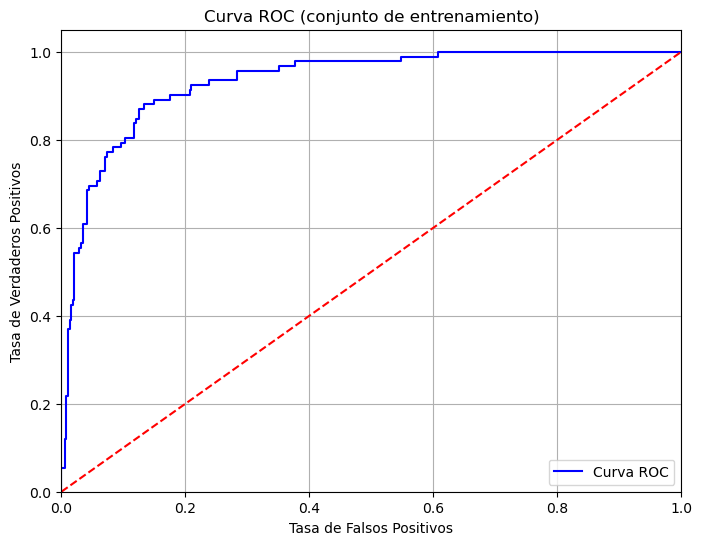

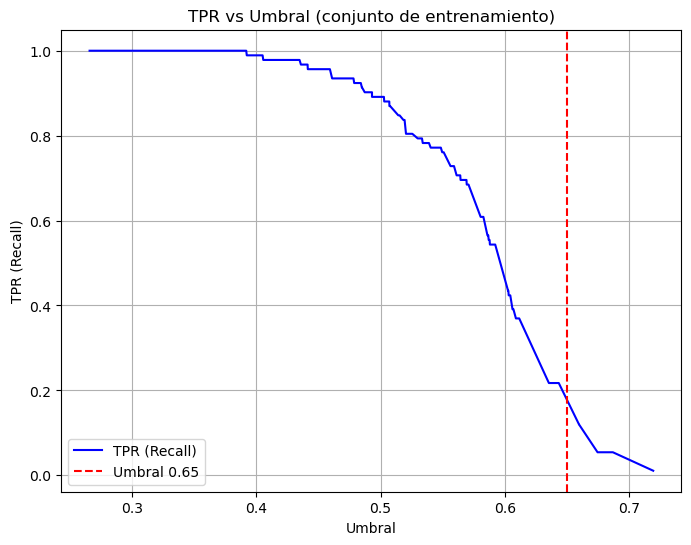

In [31]:
#show the roc curve for the model "modelo_hgb"
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt


fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_proba_train, pos_label=1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de entrenamiento)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el tpr vs el umbral para train
plt.figure(figsize=(8, 6))
plt.plot(thresholds_train, tpr_train, label='TPR (Recall)', color='blue')
plt.axvline(x=0.65, color='red', linestyle='--', label='Umbral 0.65')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral (conjunto de entrenamiento)')
plt.legend()
plt.grid()
plt.show()


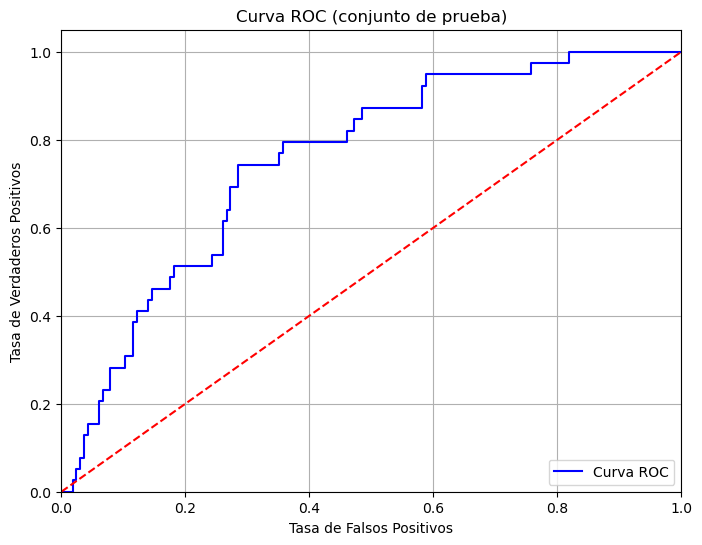

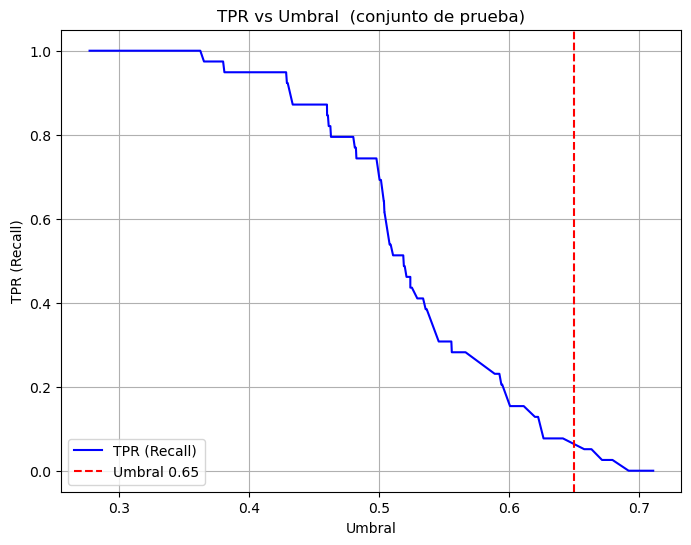

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_test, pos_label=1)
#graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC', color='blue')
plt.plot([0, 1], [0, 1], 'r--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (conjunto de prueba)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# dibuja el fpr vs el umbral
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='TPR (Recall)', color='blue')
plt.axvline(x=0.65, color='red', linestyle='--', label='Umbral 0.65')
plt.xlabel('Umbral')
plt.ylabel('TPR (Recall)')
plt.title('TPR vs Umbral  (conjunto de prueba)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#calcula el umbral óptimo para la predicción del modelo
from sklearn.metrics import f1_score

# y_test y y_proba_test ya están definidos en celdas anteriores
f1_scores = []
for thresh in thresholds:
	if np.isinf(thresh):
		continue  # saltar el primer valor inf
	y_pred_thresh = (y_proba_test >= thresh).astype(int)
	f1_scores.append(f1_score(y_test, y_pred_thresh))

# Encontrar el umbral con el F1 más alto
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[1:][best_idx]  # thresholds[0] es inf, así que lo saltamos

print(f"Mejor umbral según F1: {best_threshold:.4f}")
print(f"Mejor F1: {f1_scores[best_idx]:.4f}")

Mejor umbral según F1: 0.4982
Mejor F1: 0.5043


In [25]:
# Aplica el umbral óptimo y calcula la matriz de confusión, auc, accuracy y f1score

from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score

# Usa el mejor umbral encontrado previamente
y_pred_opt = (y_proba_test >= best_threshold).astype(int)

print("Matriz de confusión (umbral óptimo):")
print(confusion_matrix(y_test, y_pred_opt))

print(classification_report(y_test, y_pred_test))

print("\nAUC (umbral óptimo):")
print(roc_auc_score(y_test, y_proba_test))

print("\nAccuracy (umbral óptimo):")
print(accuracy_score(y_test, y_pred_opt))

print("\nF1 score (umbral óptimo):")
print(f1_score(y_test, y_pred_opt))

Matriz de confusión (umbral óptimo):
[[118  47]
 [ 10  29]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       165
           1       0.36      0.69      0.48        39

    accuracy                           0.71       204
   macro avg       0.64      0.70      0.64       204
weighted avg       0.80      0.71      0.74       204


AUC (umbral óptimo):
0.7536907536907537

Accuracy (umbral óptimo):
0.7205882352941176

F1 score (umbral óptimo):
0.5043478260869565


In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0, 1, 100)
fp_list = []
fn_list = []

for thresh in thresholds:
    y_pred_thresh = (y_proba_test >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    fp_list.append(fp)
    fn_list.append(fn)

# Umbral que minimiza FP
min_fp_idx = np.argmin(fp_list)
best_thresh_fp = thresholds[min_fp_idx]
print(f"Threshold que minimiza FP: {best_thresh_fp:.3f} (FP = {fp_list[min_fp_idx]})")

# Umbral que minimiza FN
min_fn_idx = np.argmin(fn_list)
best_thresh_fn = thresholds[min_fn_idx]
print(f"Threshold que minimiza FN: {best_thresh_fn:.3f} (FN = {fn_list[min_fn_idx]})")


Threshold que minimiza FP: 0.717 (FP = 0)
Threshold que minimiza FN: 0.000 (FN = 0)


In [17]:
# Matriz de confusión con el threshold que minimiza FP
y_pred_fp = (y_proba_test >= best_thresh_fp).astype(int)
print("\nMatriz de confusión con threshold que minimiza FP:")
print(confusion_matrix(y_test, y_pred_fp))

# Matriz de confusión con el threshold que minimiza FN
y_pred_fn = (y_proba_test >= best_thresh_fn).astype(int)
print("\nMatriz de confusión con threshold que minimiza FN:")
print(confusion_matrix(y_test, y_pred_fn))




Matriz de confusión con threshold que minimiza FP:
[[165   0]
 [ 39   0]]

Matriz de confusión con threshold que minimiza FN:
[[  0 165]
 [  0  39]]


In [26]:
# Matriz de confusión con el threshold que minimiza FN
y_pred_fn = (y_proba_test >= 0.37).astype(int)
print("\nMatriz de confusión con threshold que minimiza FN:")
print(confusion_matrix(y_test, y_pred_fn))

print("\nAUC (umbral 0.37):")
print(roc_auc_score(y_test, y_proba_test))

print("\nAccuracy (umbral 0.37):")
print(accuracy_score(y_test, y_pred_fn))

print("\nF1 score (umbral 0.37):")
print(f1_score(y_test, y_pred_fn))




Matriz de confusión con threshold que minimiza FN:
[[ 35 130]
 [  1  38]]

AUC (umbral 0.37):
0.7536907536907537

Accuracy (umbral 0.37):
0.35784313725490197

F1 score (umbral 0.37):
0.3671497584541063


In [22]:
# Matriz de confusión con el threshold que minimiza FN
y_pred_fn = (y_proba_test >= 0.36).astype(int)
print("\nMatriz de confusión con threshold que minimiza FN:")
print(confusion_matrix(y_test, y_pred_fn))

print("\nAUC (umbral 0.36):")
print(roc_auc_score(y_test, y_pred_fn))

print("\nAccuracy (umbral 0.36):")
print(accuracy_score(y_test, y_pred_fn))

print("\nF1 score (umbral 0.36):")
print(f1_score(y_test, y_pred_fn))


Matriz de confusión con threshold que minimiza FN:
[[ 28 137]
 [  0  39]]

AUC (umbral 0.36):
0.5848484848484848

Accuracy (umbral 0.36):
0.3284313725490196

F1 score (umbral 0.36):
0.3627906976744186


In [ ]:
# Matriz de confusión con el threshold que minimiza FN
y_pred_fn = (y_proba_test >= 0.7).astype(int)
print("\nMatriz de confusión con threshold que minimiza FP:")
print(confusion_matrix(y_test, y_pred_fn))


Matriz de confusión con threshold que minimiza FN:
[[164   1]
 [ 39   0]]


In [42]:
# Matriz de confusión con el threshold que minimiza FN
y_pred_fn = (y_proba_test >= 0.65).astype(int)
print("\nMatriz de confusión con threshold que minimiza FP:")
print(confusion_matrix(y_test, y_pred_fn))


Matriz de confusión con threshold que minimiza FP:
[[160   5]
 [ 37   2]]
